<a href="https://colab.research.google.com/github/Voidmort/Kaggle-Notes/blob/master/Titanic_Machine_Learning_from_Disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
title: Titanic: Machine Learning from Disaster
date: 2019-05-028
tags: [Kaggle]
categories: [Kaggle]
---

Kaggle Competition 的练习

[泰坦尼克号：从灾难中学习机器](https://www.kaggle.com/c/titanic)

In [0]:
# 数据分析库
import pandas as pd
import numpy as np
import random

# 数据可视化
import seaborn as sns
import matplotlib.pyplot as plt

# 机器学习库
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

pd.options.display.max_rows = 10  # 最大显示行数
pd.options.display.float_format = '{:.5f}'.format  # 精确度 保留一位小数

# 加载数据

首先加载浏览数据

In [0]:
train_df = pd.read_csv('/train.csv')
test_df = pd.read_csv('/test.csv')

In [0]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00000,1,0,A/5 21171,7.25000,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00000,1,0,PC 17599,71.28330,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00000,0,0,STON/O2. 3101282,7.92500,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00000,1,0,113803,53.10000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00000,0,0,373450,8.05000,NaN,S


In [0]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.50000,0,0,330911,7.82920,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00000,1,0,363272,7.00000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.00000,0,0,240276,9.68750,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.00000,0,0,315154,8.66250,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00000,1,1,3101298,12.28750,NaN,S


In [0]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.00000,891.00000,891.00000,714.00000,891.00000,891.00000,891.00000
mean,446.00000,0.38384,2.30864,29.69912,0.52301,0.38159,32.20421
std,257.35384,0.48659,0.83607,14.52650,1.10274,0.80606,49.69343
min,1.00000,0.00000,1.00000,0.42000,0.00000,0.00000,0.00000
25%,223.50000,0.00000,2.00000,20.12500,0.00000,0.00000,7.91040
50%,446.00000,0.00000,3.00000,28.00000,0.00000,0.00000,14.45420
75%,668.50000,1.00000,3.00000,38.00000,1.00000,0.00000,31.00000
max,891.00000,1.00000,3.00000,80.00000,8.00000,6.00000,512.32920


In [0]:
test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.00000,418.00000,332.00000,418.00000,418.00000,417.00000
mean,1100.50000,2.26555,30.27259,0.44737,0.39234,35.62719
std,120.81046,0.84184,14.18121,0.89676,0.98143,55.90758
min,892.00000,1.00000,0.17000,0.00000,0.00000,0.00000
25%,996.25000,1.00000,21.00000,0.00000,0.00000,7.89580
50%,1100.50000,3.00000,27.00000,0.00000,0.00000,14.45420
75%,1204.75000,3.00000,39.00000,1.00000,0.00000,31.50000
max,1309.00000,3.00000,76.00000,8.00000,9.00000,512.32920


训练集有 PassengerId	Survived	Pclass	Name	Sex	Age	SibSp	Parch	Ticket	Fare	Cabin	Embarked 共十二列数据，测试集中没有的Survived就是我们要预测的值。

## 检查数据



检查数据类型和缺失情况。

In [0]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

观察发现，Age Cabin Embarked 存在缺失，并且数据类型既有数字也有字符串。测试集中 Fare 缺失了一个。

## 观察特征的分布

    Name 是唯一的共 891
    Sex 有两种，male 占 64.7%（top=male, freq/count=64.7%）
    Ticket 不同的种类比较多
    Cabin 有许多乘客在同一个 cabin
    Embarked 有三种大多数是 S

In [0]:
train_df.describe(include=["O"])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Renouf, Mr. Peter Henry",male,1601,C23 C25 C27,S
freq,1,577,7,4,644


# 数据预处理


在训练集中存在着缺失值和错误值，所以要筛选出有价值的特征，填充缺失的数据。

## 删除

首先删除没有价值或价值比较低的特征。

根据我们的假设和决定，我们先放弃 Cabin 和 Ticket 。

我们对训练和测试数据集执行相同的操作以保持其一致。

In [0]:
print("Before", train_df.shape, test_df.shape)

train_df = train_df.drop(["Ticket", "Cabin"], axis=1)
test_df = test_df.drop(["Ticket", "Cabin"], axis=1)
combine = [train_df, test_df]

"After", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape

Before (891, 12) (418, 11)


('After', (891, 10), (418, 9), (891, 10), (418, 9))

## Name

首先观察到 Name 都是唯一的并且在 Name 中间存在称谓，提取出名字中间的称谓。

In [0]:
for dataset in combine:
    dataset["Title"] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    
pd.crosstab(train_df["Title"], train_df["Sex"])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
...,...,...
Mr,0,517
Mrs,125,0
Ms,1,0


把称呼替换为更为常见的，不常见的定义为 Rare

In [0]:
for dataset in combine:
    dataset["Title"] = dataset["Title"].replace(["Lady", "Countess", "Capt", "Col", \
                                                 "Don", "Dr", "Major", "Rev", "Sir", \
                                                 "Jonkheer", "Dona"], "Rare")
    dataset["Title"] = dataset["Title"].replace("Mlle", "Miss")
    dataset["Title"] = dataset["Title"].replace("Ms", "Miss")
    dataset["Title"] = dataset["Title"].replace("Mme", "Mrs")

train_df[["Title", "Survived"]].groupby(["Title"], as_index=False).mean()

,Title,Survived
0,Master,0.57500
1,Miss,0.70270
2,Mr,0.15667
3,Mrs,0.79365
4,Rare,0.34783


把 Titles 转换为数字

In [0]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset["Title"] = dataset["Title"].map(title_mapping)
    dataset["Title"] = dataset["Title"].fillna(0) # 缺失值补0

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00000,1,0,7.25000,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00000,1,0,71.28330,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00000,0,0,7.92500,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00000,1,0,53.10000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.00000,0,0,8.05000,S,1


现在可以删除 Name 和 PassengerId了

In [0]:
train_df = train_df.drop(["Name", "PassengerId"], axis=1)
test_df = test_df.drop(["Name"], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 9))

## Sex

将包含字符串的特征转换为数值。这是大多数模型算法所必需的。这样做也将有助于我们实现功能完成目标。

让我们首先将 Sex 特征转换为一个新的 feature，其中 female = 1，male = 0。

In [0]:
for dataset in combine:
    dataset["Sex"] = dataset["Sex"].map({"female": 1, "male": 0}).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.00000,1,0,7.25000,S,1
1,1,1,1,38.00000,1,0,71.28330,C,3
2,1,3,1,26.00000,0,0,7.92500,S,2
3,1,1,1,35.00000,1,0,53.10000,S,3
4,0,3,0,35.00000,0,0,8.05000,S,1


## Age

现在处理缺少值或空值的问题。
我们首先处理 Age 。

可以考虑三种方法来完成特征的填充。

1. 一种简单的方法是在均值的标准差之间生成随机数。

2. 使用其他相关特征猜测缺失值。在这个例子中，我们注意到 Age，Gender 和 Pclass 之间的相关性。用猜年龄值中位值跨越套 Pclass 和性别特征组合年龄。因此，Pclass 的中位数年龄 = 1且性别 = 0，Pclass = 1 且性别 = 1，依此类推......

3. 结合方法1和2因此，不是基于中位数来猜测年龄值，而是根据Pclass和Gender组合的集合使用均值和标准差之间的随机数。

方法1和3将随机噪声引入我们的模型。多次执行的结果可能会有所不同。我们选择方法2。

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


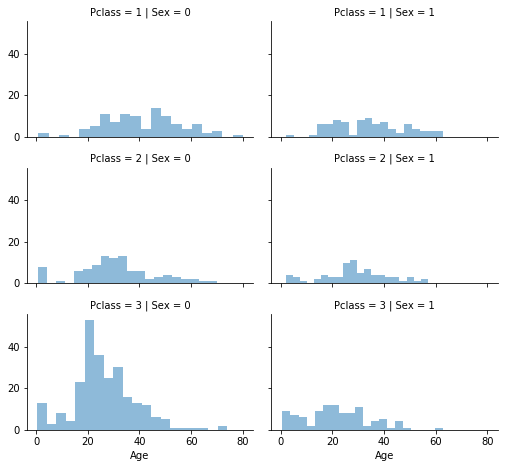

In [0]:
grid = sns.FacetGrid(train_df, row="Pclass", col="Sex", size=2.2, aspect=1.6)
grid.map(plt.hist, "Age", alpha=0.5, bins=20)
grid.add_legend()

首先准备一个空数组，猜测 Age 和 Pclass × Geender 有关系

In [0]:
guess_ages = np.zeros((2, 3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

现在我们迭代 Sex(0,1) 和 Pclass(1,2,3) 来猜测这六种组合的 Age。

In [0]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset["Sex"] == i) & (dataset["Pclass"] == j+1)]["Age"].dropna()
            age_guess = guess_df.median()
            guess_ages[i, j] = int(age_guess/0.5 + 0.5) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[(dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1), "Age"] = guess_ages[i, j]
    
    dataset["Age"] = dataset["Age"].astype(int)
    
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.25000,S,1
1,1,1,1,38,1,0,71.28330,C,3
2,1,3,1,26,0,0,7.92500,S,2
3,1,1,1,35,1,0,53.10000,S,3
4,0,3,0,35,0,0,8.05000,S,1


让我们创建 AgeBand，并确定与存活的相关性。

In [0]:
# 把Age分为5箱
train_df["AgeBand"] = pd.cut(train_df["Age"], 5)
train_df[["AgeBand", "Survived"]].groupby(["AgeBand"], as_index=False).mean().sort_values(by="AgeBand", ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.55000
1,"(16.0, 32.0]",0.33737
2,"(32.0, 48.0]",0.41204
3,"(48.0, 64.0]",0.43478
4,"(64.0, 80.0]",0.09091


用这个频率来把 Age 分为五箱来替代原 Age。

In [0]:
for dataset in combine:
    dataset.loc[dataset["Age"] <= 16, "Age"] = 0
    dataset.loc[(dataset["Age"] > 16) & (dataset["Age"] <= 32), "Age"] = 1
    dataset.loc[(dataset["Age"] > 32) & (dataset["Age"] <= 48), "Age"] = 2
    dataset.loc[(dataset["Age"] > 48) & (dataset["Age"] <= 64), "Age"] = 3
    dataset.loc[dataset["Age"] > 64, "Age"] = 4

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.25000,S,1,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.28330,C,3,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.92500,S,2,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.10000,S,3,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.05000,S,1,"(32.0, 48.0]"


移除 AgeBand feature

In [0]:
train_df = train_df.drop(["AgeBand"], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.25000,S,1
1,1,1,1,2,1,0,71.28330,C,3
2,1,3,1,1,0,0,7.92500,S,2
3,1,1,1,2,1,0,53.10000,S,3
4,0,3,0,2,0,0,8.05000,S,1


## Embarked

Embarked 特征取值为 S、Q、C。我们的训练数据集有两个缺失的值。用最常见的 Embarked 来填充（众数填充）。

In [0]:
freq_port = train_df.Embarked.dropna().mode()[0] # 返回出现次数最多的值（众数）
freq_port

'S'

In [0]:
for dataset in combine:
    dataset["Embarked"] = dataset["Embarked"].fillna(freq_port)
    
train_df[["Embarked", "Survived"]].groupby(["Embarked"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,Embarked,Survived
0,C,0.55357
1,Q,0.38961
2,S,0.33901


现在，我们可以把 Embarked 转换为一个新的数字序列。

In [0]:
for dataset in combine:
    dataset["Embarked"] = dataset["Embarked"].map( {"S": 0, "C": 1, "Q": 2} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.25000,0,1
1,1,1,1,2,1,0,71.28330,1,3
2,1,3,1,1,0,0,7.92500,0,2
3,1,1,1,2,1,0,53.10000,0,3
4,0,3,0,2,0,0,8.05000,0,1


## Fare

现在，我们可以使用 df.fillna 填充 test dataset 中 Fare 的单个缺失值，使用 median （中位数）来填充。我们只需要一行代码就可以做到这一点。

注意，我们并没有创建一个中间的新特性，也没有对相关性进行任何进一步的分析来猜测缺失的特性，因为我们只是替换了一个值。以达到了模型算法对非空值运算的要求。

In [0]:
test_df["Fare"].fillna(test_df["Fare"].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,0,2,0,0,7.82920,2,1
1,893,3,1,2,1,0,7.00000,0,3
2,894,2,0,3,0,0,9.68750,2,1
3,895,3,0,1,0,0,8.66250,0,1
4,896,3,1,1,1,1,12.28750,0,3


创建一个 FareBand

In [0]:
train_df["FareBand"] = pd.qcut(train_df["Fare"], 4)
train_df[["FareBand", "Survived"]].groupby(["FareBand"], as_index=False).mean().sort_values(by="FareBand", ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.19731
1,"(7.91, 14.454]",0.30357
2,"(14.454, 31.0]",0.45495
3,"(31.0, 512.329]",0.58108


基于 FareBand 将 Fare 转换为序列值。

In [0]:
for dataset in combine:
    dataset.loc[dataset["Fare"] <= 7.91, "Fare"] = 0
    dataset.loc[(dataset["Fare"] > 7.91) & (dataset["Fare"] <= 14.454), "Fare"] = 1
    dataset.loc[(dataset["Fare"] > 14.454) & (dataset["Fare"] <= 31), "Fare"] = 2
    dataset.loc[dataset["Fare"] > 31, "Fare"] = 3
    dataset["Fare"] = dataset["Fare"].astype(int)

train_df = train_df.drop(["FareBand"], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,0,0,1
1,1,1,1,2,1,0,3,1,3
2,1,3,1,1,0,0,1,0,2
3,1,1,1,2,1,0,3,0,3
4,0,3,0,2,0,0,1,0,1


# 模型预测

In [0]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

In [0]:
X_train.describe()
X_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,3,0,2,0,0,0,2,1
1,3,1,2,1,0,0,0,3
2,2,0,3,0,0,1,2,1
3,3,0,1,0,0,1,0,1
4,3,1,1,1,1,1,0,3
...,...,...,...,...,...,...,...,...
413,3,0,1,0,0,1,0,1
414,1,1,2,0,0,3,1,5
415,3,0,2,0,0,0,0,1
416,3,0,1,0,0,1,0,1


现在，我们准备训练一个模型并预测。有60多种预测建模算法可供选择。我们必须了解问题的类型和解决方案的需求，以便将范围缩小到我们可以评估的几个选定的模型。

我们的问题是一个分类和回归问题。我们想要确定输出(Survived or not)与其他变量或特性(Gender, Age, Port……)之间的关系。这是一个监督学习。有了这两个标准 —— 监督学习加上分类和回归，我们可以把模型的选择范围缩小到几个。

这些包括:

- 逻辑回归
- KNN或k近邻
- 支持向量机
- 朴素贝叶斯分类器
- 决策树
- 随机森林
- 感知器
- 随机梯度下降
- RVM 相关向量机

In [0]:
# 逻辑回归

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


81.37

我们可以使用逻辑回归来验证和检查我们的预测。可以通过计算决策函数中特征的系数来实现。

正系数增加了响应的 log-odds (从而增加了概率)，负系数减少了响应的 log-odds (从而减少了概率)。
性别是正系数最高的，说明随着性别值的增加(男性: 0 女性:1)，存活的概率增加最多。
相反，随着 Pclass 的增加，生存概率下降。
这样，Age 是一个很好的人工特征，因为它与存活有第二高的负相关。
Title 也是第二高的正相关。

In [0]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.19360
7,Title,0.49431
5,Fare,0.31180
6,Embarked,0.24051
4,Parch,-0.25322
3,SibSp,-0.50649
2,Age,-0.65716
0,Pclass,-0.91037


其次，我们使用支持向量机建模，这是监督学习的算法，用于数据分类和回归分析。给定一组训练样本，每个样本都被标记为属于两个类别中的一个或另一个类别，SVM训练算法建立一个模型，将新的测试样本分配给其中一个类别或另一个类别，使其成为一个非概率二元线性分类器。

该模型生成的评分高于逻辑回归模型。

In [0]:
# Support Vector Machines

svm = SVC()
svm.fit(X_train, Y_train)
Y_pred = svm.predict(X_test)
acc_svm = round(svm.score(X_train, Y_train) * 100, 2)
acc_svm

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


83.73

在模式识别中，k近邻算法(简称k-NN)是一种用于分类和回归的非参数算法。一个样本由它的邻居的多数投票来分类，这个样本被分配到它的k个最近邻居中最常见的类(k是一个正整数，通常很小)。如果 k = 1，那么对象就被简单地分配给那个最近邻居的类。

KNN得分优于logistic回归，但低于SVM。

In [0]:
# KNN

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

84.4

在机器学习中，朴素贝叶斯分类器是一组基于贝叶斯定理的简单概率分类器，特征之间具有强(朴素)独立性假设。朴素贝叶斯分类器是高度可伸缩的，在一个学习问题中需要一些参数在变量(特征)的数量上是线性的。

模型生成的置信度评分是目前评价模型中最低的。

In [0]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

80.13

感知器是一种二进制分类器的监督学习算法(函数，它可以决定一个输入是否属于某个特定的类，由一个数字向量表示)。它是一种线性分类器，即基于一组权值与特征向量相结合的线性预测函数进行预测的分类算法。该算法允许在线学习，每次处理训练集中的一个元素。

In [0]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

80.58

In [0]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


81.14

In [0]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

80.92

使用决策树作为预测模型，是一种十分常用的分类方法。他是一种监管学习，所谓监管学习就是给定一堆样本，每个样本都有一组属性和一个类别，这些类别是事先确定的，那么通过学习得到一个分类器，这个分类器能够对新出现的对象给出正确的分类。

目前模型中最高的评分。

In [0]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

89.0

下一个模型随机森林是最受欢迎的之一。一个包含多个决策树的分类器， 并且其输出的类别是由个别树输出的类别的众数而定。

模型目前评分中最高的。我们决定使用这个模型的输出(Y_pred)提交结果。

In [0]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

89.0

## 模型评价
现在我们可以对所有模型的评估进行排序，以选择最适合我们问题的模型。在决策树和随机森林得分相同的情况下，我们选择随机森林来纠正决策树对训练集过度拟合的习惯。

In [0]:
models = pd.DataFrame({
    "Model": ["Support Vector Machines", "KNN", "Logistic Regression",
              "Random Forest", "Naive Bayes", "Percep tron",
              "Stochastic Gradient Decent", "Linear SVC", "Decision Tree"],
    "Score": [acc_svm, acc_knn, acc_log, acc_random_forest, acc_gaussian,
              acc_perceptron, acc_sgd, acc_linear_svc, acc_decision_tree]
    })
models.sort_values(by="Score", ascending=False)

,Model,Score
3,Random Forest,89.00000
8,Decision Tree,89.00000
1,KNN,84.40000
0,Support Vector Machines,83.73000
2,Logistic Regression,81.37000
7,Linear SVC,81.14000
6,Stochastic Gradient Decent,80.92000
5,Percep tron,80.58000
4,Naive Bayes,80.13000


In [0]:
# 保存结果

submission = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],
    "Survived": Y_pred
    })
submission.to_csv("/submission.csv", index=False)